In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [ ]:
SEED = 1234

In [ ]:
def set_seeds(seed=1234):
    """set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # for multi-gpu setup

In [ ]:
set_seeds(SEED)

In [ ]:
# cuda = False
device = torch.device('cuda' if
                      torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.FloatTensor')
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

print(device)

cpu


In [ ]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


In [ ]:
# unique news categories
np.unique(df['category'])

array(['Business', 'Sci/Tech', 'Sports', 'World'], dtype=object)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
print(f"Stowords: {STOPWORDS[:5]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Stowords: ['i', 'me', 'my', 'myself', 'we']


In [ ]:
porter = PorterStemmer()

In [ ]:
def preprocess(text, stopwords=STOPWORDS):
    """conditional preprocessing on text"""
    # lowercase
    text = text.lower()

    # remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # remove words in paranthesis
    text = re.sub(r'\([^)]*\)', '', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    return text

In [ ]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [ ]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says

sharon accepts plan reduce gaza army operation haaretz says


In [ ]:
preprocessed_df.title.values[:5]

array(['sharon accepts plan reduce gaza army operation haaretz says',
       'internet key battleground wildlife crime fight',
       'july durable good orders rise 1 7 percent',
       'growing signs slowing wall street', 'new faces reality tv'],
      dtype=object)

In [ ]:
import collections
from sklearn.model_selection import train_test_split

In [ ]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [ ]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [ ]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: extinct humans left louse legacy → Sci/Tech


In [ ]:
import itertools

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [ ]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: Sci/Tech
y_train[0]: 1


In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


In [ ]:
# Tokenization
import json
from collections import Counter
from more_itertools import take

In [ ]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token='<PAD>', oov_token='<UNK>',
                 token_to_index=None):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        print(type(texts))
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(' ')
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'char_level': self.char_level,
                'oov_token': self.oov_token,
                'token_to_index': self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
X_train

array(['extinct humans left louse legacy',
       'michigan st beats central conn st',
       'least one saudi policeman killed clashes gunmen', ..., 'alan key',
       'google founders honored marconi foundation',
       'man builds 7 foot grandfather clock lego'], dtype=object)

In [ ]:
# tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=500)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(tokenizer)

<Tokenizer(num_tokens=500)>


In [ ]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 165


In [ ]:
X_train

array(['extinct humans left louse legacy',
       'michigan st beats central conn st',
       'least one saudi policeman killed clashes gunmen', ..., 'alan key',
       'google founders honored marconi foundation',
       'man builds 7 foot grandfather clock lego'], dtype=object)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Text to indices:
  (preprocessed) → <UNK> <UNK> <UNK> <UNK> <UNK>
  (tokenized) → [1 1 1 1 1]


In [ ]:
def to_categorical(seq, num_classes):
    """one-hot encode a sequence of tokens"""
    one_hot = np.zeros((len(seq), num_classes))
    for i, item in enumerate(seq):
        one_hot[i, item] = 1
    return one_hot

In [ ]:
# One-hot encoding
print (X_train[0])
print (len(X_train[0]))
cat = to_categorical(seq=X_train[0], num_classes=len(tokenizer))
print (cat)
print (cat.shape)

[1 1 1 1 1]
5
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(5, 500)


In [ ]:
# Convert tokens to one-hot
vocab_size = len(tokenizer)
X_train = [to_categorical(seq, num_classes=vocab_size) for seq in X_train]
X_val = [to_categorical(seq, num_classes=vocab_size) for seq in X_val]
X_test = [to_categorical(seq, num_classes=vocab_size) for seq in X_test]

In [ ]:
# one hot encode: (N, max_seq_len, vocab_size)
def pad_sequences(sequences, max_seq_len=0):
    """pad sequences to max length in sequence"""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    num_classes = sequences[0].shape[-1]
    padded_sequences = np.zeros((len(sequences), max_seq_len, num_classes))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [ ]:
# 3D sequences
print (X_train[0].shape, X_train[1].shape, X_train[2].shape)
padded = pad_sequences(X_train[0:3])
print (padded.shape)

(5, 500) (6, 500) (7, 500)
(3, 7, 500)


In [ ]:
padded

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]])

In [ ]:
# Dataset
FILTER_SIZE = 1 #unigram

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        y = np.stack(batch[:,1], axis=0)

        # pad sequences
        X = pad_sequences(X, max_seq_len=self.max_filter_size)

        X = torch.FloatTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(dataset=self, batch_size=batch_size,
                                           collate_fn=self.collate_fn, 
                                           shuffle=shuffle, drop_last=drop_last,
                                           pin_memory=True)

In [ ]:
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=FILTER_SIZE)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=FILTER_SIZE)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=FILTER_SIZE)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {test_dataset[0][0]}\n"
    f"  y: {test_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
  y: 2


In [ ]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(test_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 13, 500]
  y: [64]
Sample point:
  X: tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
  y: 2


# Dummy CNN Model

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
batch_size = 64
max_seq_len = 8 # words per input
vocab_size = 10 # one hot size
x = torch.randn(batch_size, max_seq_len, vocab_size)
print(f"X: {x.shape}")
x = x.transpose(1,2)
print(f"X: {x.shape}")

X: torch.Size([64, 8, 10])
X: torch.Size([64, 10, 8])


In [ ]:
# conv filters (VALID padding)
vocab_size = 10
num_filters = 50
filter_size = 3
stride = 1
padding = 0
conv1 = nn.Conv1d(in_channels=vocab_size, out_channels=num_filters, 
                  kernel_size=filter_size, stride=stride, padding=padding,
                  padding_mode='zeros')
print("conv: {}".format(conv1.weight.shape))

conv: torch.Size([50, 10, 3])


In [ ]:
# Forward pass
z = conv1(x)
print (f"z: {z.shape}")

z: torch.Size([64, 50, 6])


In [ ]:
# Convolutional filters (SAME padding)
vocab_size = 10 # one hot size
num_filters = 50 # num filters
filter_size = 3 # filters are 3X3
stride = 1
conv = nn.Conv1d(in_channels=vocab_size, out_channels=num_filters,
                 kernel_size=filter_size, stride=stride)
print("conv: {}".format(conv.weight.shape))

conv: torch.Size([50, 10, 3])


In [ ]:
# `SAME` padding
padding_left = int((conv.stride[0]*(max_seq_len-1) - max_seq_len + filter_size)/2)
padding_right = int(math.ceil((conv.stride[0]*(max_seq_len-1) - max_seq_len + filter_size)/2))
print (f"padding: {(padding_left, padding_right)}")

padding: (1, 1)


In [ ]:
# Forward pass
z = conv(F.pad(x, (padding_left, padding_right)))
print (f"z: {z.shape}")

z: torch.Size([64, 50, 8])


In [ ]:
# Max pooling
pool_output = F.max_pool1d(z, z.size(2))
print("Size: {}".format(pool_output.shape))

Size: torch.Size([64, 50, 1])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# Batch normalization
batch_norm = nn.BatchNorm1d(num_features=num_filters)
z = batch_norm(conv(x)) # applied to activations (after conv layer & before pooling)
print (f"z: {z.shape}")

z: torch.Size([64, 50, 6])


In [ ]:
# Mean and std before batchnorm
print (f"mean: {torch.mean(conv1(x)):.2f}, std: {torch.std(conv(x)):.2f}")

mean: -0.01, std: 0.57


In [ ]:
# Mean and std after batchnorm
print (f"mean: {torch.mean(z):.2f}, std: {torch.std(z):.2f}")

mean: -0.00, std: 1.00


In [ ]:
NUM_FILTERS = 50
HIDDEN_DIM = 100
DROPOUT_P = 0.1

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                 hidden_dim, dropout_p, num_classes):
        super(CNN, self).__init__()

        self.filter_size = filter_size
        self.conv = nn.Conv1d(in_channels=vocab_size, out_channels=num_filters,
                              kernel_size=filter_size, stride=1, padding=0,
                              padding_mode='zeros')
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)

        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False, apply_softmax=False):
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2) #(N, C, L)
        
        # paddding for SAME padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))

        # conv
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))
        z = F.max_pool1d(z, z.size(2)).squeeze(2)

        # FC layer
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

In [ ]:
# Initialize model
model = CNN(vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
            hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [ ]:
from torch.optim import Adam

In [ ]:
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 2

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs, apply_softmax=True)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.87731, val_loss: 0.78343, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.78640, val_loss: 0.77561, lr: 1.00E-03, _patience: 5


In [ ]:
import json
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance['overall'], indent=2))

{
  "precision": 0.7108799265528744,
  "recall": 0.6883333333333334,
  "f1": 0.6889996132023932,
  "num_samples": 18000.0
}


In [ ]:
# Save artifacts
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, 'label_encoder.json'))
tokenizer.save(fp=Path(dir, 'tokenizer.json'))
torch.save(best_model.state_dict(), Path(dir, 'model.pt'))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [ ]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [ ]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, 'label_encoder.json'))
tokenizer = Tokenizer.load(fp=Path(dir, 'tokenizer.json'))
model = CNN(
    vocab_size=VOCAB_SIZE, num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(Path(dir, 'model.pt'), map_location=device))
model.to(device)

CNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "What a day for the new york stock market to go bust!"
sequences = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(sequences))
X = [to_categorical(seq, num_classes=len(tokenizer)) for seq in sequences]
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler, max_filter_size=FILTER_SIZE)
dataloader = dataset.create_dataloader(batch_size=batch_size)

<class 'list'>
['day new <UNK> stock market go <UNK>']


In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)

['Business']

In [ ]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))

{
  "Business": 0.8779469132423401,
  "Sci/Tech": 0.10688897967338562,
  "World": 0.012356700375676155,
  "Sports": 0.0028073955327272415
}


In [ ]:
import collections
import seaborn as sns

In [ ]:
class InterpretableCNN(nn.Module):
    def __init__(self, vocab_size, num_filters, filter_size,
                 hidden_dim, dropout_p, num_classes):
        super(InterpretableCNN, self).__init__()

        # Convolutional filters
        self.filter_size = filter_size
        self.conv = nn.Conv1d(
            in_channels=vocab_size, out_channels=num_filters,
            kernel_size=filter_size, stride=1, padding=0, padding_mode='zeros')
        self.batch_norm = nn.BatchNorm1d(num_features=num_filters)

        # FC layers
        self.fc1 = nn.Linear(num_filters, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False, apply_softmax=False):

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        x_in, = inputs
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Padding for `SAME` padding
        max_seq_len = x_in.shape[2]
        padding_left = int((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2)
        padding_right = int(math.ceil((self.conv.stride[0]*(max_seq_len-1) - max_seq_len + self.filter_size)/2))

        # Conv outputs
        z = self.conv(F.pad(x_in, (padding_left, padding_right)))

        return z

In [ ]:
# Initialize
interpretable_model = InterpretableCNN(
    vocab_size=len(tokenizer), num_filters=NUM_FILTERS, filter_size=FILTER_SIZE,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)

In [ ]:
# Load weights (same architecture)
interpretable_model.load_state_dict(torch.load(Path(dir, 'model.pt'), map_location=device))
interpretable_model.to(device)

InterpretableCNN(
  (conv): Conv1d(500, 50, kernel_size=(1,), stride=(1,))
  (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
# Initialize trainer
interpretable_trainer = Trainer(model=interpretable_model, device=device)

In [ ]:
# Get conv outputs
conv_outputs = interpretable_trainer.predict_step(dataloader)
print (conv_outputs.shape) # (num_filters, max_seq_len)

(50, 7)


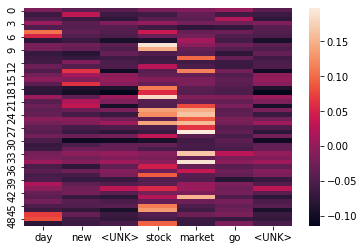

In [ ]:
# Visualize a bi-gram filter's outputs
tokens = tokenizer.sequences_to_texts(sequences)[0].split(' ')
sns.heatmap(conv_outputs, xticklabels=tokens)